In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pathlib import Path
from typing import Union

In [3]:
parent_data_dir = Path("/local-scratch2/Datasets/ISBI_ISIC/2018/Task3")

target_metadata_dir = Path("CSV_files")
target_npz_files_save_dir = Path("NPZ_files")

data_dirs = {
    "train": {
        "imgs": parent_data_dir / "ISIC2018_Task3_Training_Input",
        "lbls": parent_data_dir / "ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"
    },
    "val": {
        "imgs": parent_data_dir / "ISIC2018_Task3_Validation_Input",
        "lbls": parent_data_dir / "ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
    },
    "test": {
        "imgs": parent_data_dir / "ISIC2018_Task3_Test_Input",
        "lbls": parent_data_dir / "ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"
    }
}

dx_int_map = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "mel": 4,
    "nv": 5,
    "vasc": 6
}

In [4]:
df_metadata = {}

for split in data_dirs:
    df_metadata[split] = pd.read_csv(data_dirs[split]["lbls"], header="infer")
    # https://stackoverflow.com/a/38716553
    df_metadata[split]["diag"] = df_metadata[split][["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].idxmax(axis=1)
    # https://stackoverflow.com/a/22247593
    df_metadata[split]["diag"] = df_metadata[split]["diag"].str.lower()
    df_metadata[split]["diag_int"] = df_metadata[split]["diag"].map(dx_int_map)
    df_metadata[split]["split"] = split

combined_df = pd.concat([df_metadata[split] for split in data_dirs])
print(combined_df.shape)
print(combined_df["split"].value_counts())

(11720, 11)
train    10015
test      1512
val        193
Name: split, dtype: int64


In [5]:
combined_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,diag,diag_int,split
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,5,train
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,5,train
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,5,train
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,5,train
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,mel,4,train


In [6]:
combined_df.to_csv(target_metadata_dir / "combined_extended.csv", index=False)

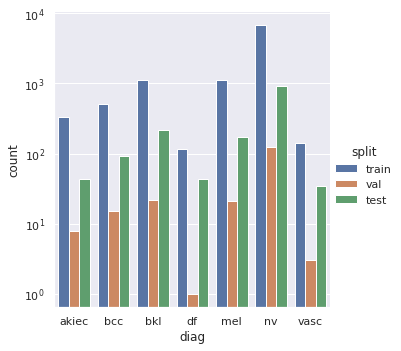

In [7]:
hue_order = ["train", "val", "test"]
dx_order = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

sns.catplot(data=combined_df, kind="count", x="diag", hue="split", order=dx_order, hue_order=hue_order)
plt.yscale("log")

In [8]:
def dataset_to_npz(data_dirs: dict, metadata_csv: Path, npz_save_dir: Path, npz_filename: str, size: int):
    
    npz_output = {}
    for split in ["train", "val", "test"]:
        npz_output[f"{split}_images"] = []
        npz_output[f"{split}_labels"] = []
        
    metadata_df = pd.read_csv(metadata_csv, header="infer")
    
    for _, row in tqdm(metadata_df.iterrows()):
        split = row["split"]
        
        image = Image.open(data_dirs[split]["imgs"] / (row["image"] + ".jpg"))
        label = row["diag"]

        resized_image = image.resize((size, size), resample=Image.BICUBIC)
        mapped_label = dx_int_map[label]

        resized_img_array = np.asarray(resized_image)
        
        npz_output[f"{split}_images"].append(resized_img_array)
        npz_output[f"{split}_labels"].append(mapped_label)
        
    for split in ["train", "val", "test"]:
        npz_output[f"{split}_images"] = np.stack(npz_output[f"{split}_images"]).astype(np.uint8)
        npz_output[f"{split}_labels"] = np.stack(npz_output[f"{split}_labels"]).reshape(-1, 1).astype(np.uint8)
        
    np.savez_compressed(
        npz_save_dir / (npz_filename + ".npz"), 
        train_images=npz_output["train_images"],
        train_labels=npz_output["train_labels"],
        val_images=npz_output["val_images"],
        val_labels=npz_output["val_labels"],
        test_images=npz_output["test_images"],
        test_labels=npz_output["test_labels"],
    )

In [9]:
dataset_to_npz(
    data_dirs=data_dirs,
    metadata_csv=target_metadata_dir / "combined_extended.csv",
    npz_save_dir=target_npz_files_save_dir,
    npz_filename="combined_extended_28",
    size=28
)

11720it [01:19, 148.33it/s]


In [10]:
dataset_to_npz(
    data_dirs=data_dirs,
    metadata_csv=target_metadata_dir / "combined_extended.csv",
    npz_save_dir=target_npz_files_save_dir,
    npz_filename="combined_extended_224",
    size=224
)

11720it [01:27, 134.33it/s]
